In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import bayes3d as b
import bayes3d.genjax
import joblib
from tqdm import tqdm
import os
import jax.numpy as jnp
import jax
import numpy as np
import genjax

import trimesh
import matplotlib.pyplot as plt

# console = genjax.pretty(show_locals=False)

In [3]:
inv = jnp.linalg.inv

In [4]:
from jax import (jit, vmap)
from xsight.utils import *
from xsight.importance import _importance_sampling, _update, _generate, _simulate, _propose
from xsight.pose import pack_pose, unpack_pose, apply_pose, from_euler, CAM_ALONG_X
from xsight.meshes import *
from xsight.plotting import *
from xsight.likelihood_b import clip_depth

key = jax.random.PRNGKey(0)

In [5]:
b.setup_visualizer()

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7000/static/


In [6]:
_scaling = 1.0/1000.0
_far     = 5.0

intrinsics = b.Intrinsics(
    height = 100,
    width  = 100,
    fx = 450.0, fy = 450.0,
    cx = 50.0,  cy = 50.0,
    near = 0.01, far = _far
)

b.setup_renderer(intrinsics)
model_dir = os.path.join(b.utils.get_assets_dir(),"bop/ycbv/models")
meshes = []
for idx in range(1,22):
    mesh_path = os.path.join(model_dir,"obj_" + "{}".format(idx).rjust(6, '0') + ".ply")
    mesh = trimesh.load(mesh_path)
    mesh.vertices *= _scaling 
    meshes.append(mesh)
    b.RENDERER.add_mesh_from_file(mesh_path, scaling_factor=_scaling)

b.RENDERER.add_mesh_from_file(os.path.join(b.utils.get_assets_dir(), "sample_objs/cube.obj"), scaling_factor=1.0/1000000000.0)


Increasing frame buffer size to (width, height, depth) = (128, 128, 1024)


[E rasterize_gl.cpp:121] OpenGL version reported as 4.6


In [7]:
from bayes3d.genjax.genjax_distributions import *
from xsight.likelihood_b import make_blurred_sensor_model, make_blurred_sensor_model_2

def make_constrain_adder(sensor_model_type):

    def add_constraints(X, ch=None):
        assert X.shape[-1] == 3 or X.shape[-1] == 4
        
        D  = jnp.linalg.norm(X[...,:3].reshape(-1,3), axis=-1)
        D = jnp.clip(D, 0.0, _far)
        
        if ch is None: ch = genjax.choice_map({})

        match sensor_model_type:
            case "blurred" : 
                ch["image"] = genjax.choice_map({"X": genjax.vector_choice_map({"measurement": D})})
            case "blurred2" : 
                ch["image"] = genjax.choice_map({"X": genjax.vector_choice_map({"measurement": D})})
            case "baseline": 
                ch["image"] = X[...,:3]
        
        return ch

    return add_constraints



def make_model(sensor_model_type):

    @genjax.gen
    def model_0(array, possible_object_indices, pose_bounds, contact_bounds, all_box_dims, outlier_volume, focal_length):
        
        indices        = jnp.array([], dtype=jnp.int32)
        root_poses     = jnp.zeros((0,4,4))
        contact_params = jnp.zeros((0,3))
        faces_parents  = jnp.array([], dtype=jnp.int32)
        faces_child    = jnp.array([], dtype=jnp.int32)
        parents        = jnp.array([], dtype=jnp.int32)

        for i in range(array.shape[0]):

            index = uniform_discrete(possible_object_indices) @ f"id_{i}"

            pose = uniform_pose(pose_bounds[0], pose_bounds[1]) @ f"root_pose_{i}"

            params = contact_params_uniform(contact_bounds[0], contact_bounds[1]) @ f"contact_params_{i}"

            parent_obj = uniform_discrete(jnp.arange(-1,array.shape[0] - 1)) @ f"parent_{i}"
            parent_face = uniform_discrete(jnp.arange(0,6)) @ f"face_parent_{i}"
            child_face = uniform_discrete(jnp.arange(0,6)) @ f"face_child_{i}"

            indices = jnp.concatenate([indices, jnp.array([index])])
            root_poses = jnp.concatenate([root_poses, pose.reshape(1,4,4)])
            contact_params = jnp.concatenate([contact_params, params.reshape(1,-1)])
            parents = jnp.concatenate([parents, jnp.array([parent_obj])])
            faces_parents = jnp.concatenate([faces_parents, jnp.array([parent_face])])
            faces_child = jnp.concatenate([faces_child, jnp.array([child_face])])
        
        box_dims = all_box_dims[indices]
        poses = b.scene_graph.poses_from_scene_graph(
            root_poses, box_dims, parents, contact_params, faces_parents, faces_child)

        camera_pose = uniform_pose(
            pose_bounds[0], 
            pose_bounds[1], 
        ) @ f"camera_pose"

        rendered = b.RENDERER.render(
            jnp.linalg.inv(camera_pose) @ poses , indices
        )[...,:3]

        variance = genjax.distributions.tfp_uniform(0.00000000001, 10000.0) @ "variance"
        outlier_prob  = genjax.distributions.tfp_uniform(-0.01, 10000.0) @ "outlier_prob"
        image = image_likelihood(rendered, variance, outlier_prob, outlier_volume, focal_length)  @ "image"

        return rendered, indices, poses, parents, contact_params, faces_parents, faces_child, root_poses, image


    img_likelihood = make_blurred_sensor_model(_far, 3)

    @genjax.gen
    def model_1(array, possible_object_indices, pose_bounds, contact_bounds, all_box_dims, outlier_volume, focal_length):
        
        indices        = jnp.array([], dtype=jnp.int32)
        root_poses     = jnp.zeros((0,4,4))
        contact_params = jnp.zeros((0,3))
        faces_parents  = jnp.array([], dtype=jnp.int32)
        faces_child    = jnp.array([], dtype=jnp.int32)
        parents        = jnp.array([], dtype=jnp.int32)

        for i in range(array.shape[0]):

            index = uniform_discrete(possible_object_indices) @ f"id_{i}"

            pose = uniform_pose(pose_bounds[0], pose_bounds[1]) @ f"root_pose_{i}"

            params = contact_params_uniform(contact_bounds[0], contact_bounds[1]) @ f"contact_params_{i}"

            parent_obj = uniform_discrete(jnp.arange(-1,array.shape[0] - 1)) @ f"parent_{i}"
            parent_face = uniform_discrete(jnp.arange(0,6)) @ f"face_parent_{i}"
            child_face = uniform_discrete(jnp.arange(0,6)) @ f"face_child_{i}"

            indices = jnp.concatenate([indices, jnp.array([index])])
            root_poses = jnp.concatenate([root_poses, pose.reshape(1,4,4)])
            contact_params = jnp.concatenate([contact_params, params.reshape(1,-1)])
            parents = jnp.concatenate([parents, jnp.array([parent_obj])])
            faces_parents = jnp.concatenate([faces_parents, jnp.array([parent_face])])
            faces_child = jnp.concatenate([faces_child, jnp.array([child_face])])
        
        box_dims = all_box_dims[indices]
        poses = b.scene_graph.poses_from_scene_graph(
            root_poses, box_dims, parents, contact_params, faces_parents, faces_child)

        camera_pose = uniform_pose(
            pose_bounds[0], 
            pose_bounds[1], 
        ) @ f"camera_pose"

        rendered = b.RENDERER.render(
            jnp.linalg.inv(camera_pose) @ poses , indices
        )[...,:3]

        variance = genjax.distributions.tfp_uniform(0.00000000001, 10000.0) @ "variance"
        outlier_prob  = genjax.distributions.tfp_uniform(-0.01, 10000.0) @ "outlier_prob"
        # image = image_likelihood(rendered, variance, outlier_prob, outlier_volume, focal_length) 
        image = img_likelihood(rendered, jnp.sqrt(variance), outlier_prob) @ "image"

        return rendered, indices, poses, parents, contact_params, faces_parents, faces_child, root_poses, image

    img_likelihood2 = make_blurred_sensor_model_2(_far, 3)

    @genjax.gen
    def model_2(array, possible_object_indices, pose_bounds, contact_bounds, all_box_dims, outlier_volume, focal_length):
        
        indices        = jnp.array([], dtype=jnp.int32)
        root_poses     = jnp.zeros((0,4,4))
        contact_params = jnp.zeros((0,3))
        faces_parents  = jnp.array([], dtype=jnp.int32)
        faces_child    = jnp.array([], dtype=jnp.int32)
        parents        = jnp.array([], dtype=jnp.int32)

        for i in range(array.shape[0]):

            index = uniform_discrete(possible_object_indices) @ f"id_{i}"

            pose = uniform_pose(pose_bounds[0], pose_bounds[1]) @ f"root_pose_{i}"

            params = contact_params_uniform(contact_bounds[0], contact_bounds[1]) @ f"contact_params_{i}"

            parent_obj = uniform_discrete(jnp.arange(-1,array.shape[0] - 1)) @ f"parent_{i}"
            parent_face = uniform_discrete(jnp.arange(0,6)) @ f"face_parent_{i}"
            child_face = uniform_discrete(jnp.arange(0,6)) @ f"face_child_{i}"

            indices = jnp.concatenate([indices, jnp.array([index])])
            root_poses = jnp.concatenate([root_poses, pose.reshape(1,4,4)])
            contact_params = jnp.concatenate([contact_params, params.reshape(1,-1)])
            parents = jnp.concatenate([parents, jnp.array([parent_obj])])
            faces_parents = jnp.concatenate([faces_parents, jnp.array([parent_face])])
            faces_child = jnp.concatenate([faces_child, jnp.array([child_face])])
        
        box_dims = all_box_dims[indices]
        poses = b.scene_graph.poses_from_scene_graph(
            root_poses, box_dims, parents, contact_params, faces_parents, faces_child)

        camera_pose = uniform_pose(
            pose_bounds[0], 
            pose_bounds[1], 
        ) @ f"camera_pose"

        rendered = b.RENDERER.render(
            jnp.linalg.inv(camera_pose) @ poses , indices
        )[...,:3]

        variance = genjax.distributions.tfp_uniform(0.00000000001, 10000.0) @ "variance"
        outlier_prob  = genjax.distributions.tfp_uniform(-0.01, 10000.0) @ "outlier_prob"
        image = img_likelihood2(rendered, jnp.sqrt(variance), outlier_prob) @ "image"

        return rendered, indices, poses, parents, contact_params, faces_parents, faces_child, root_poses, image


    match sensor_model_type:
        case "baseline": return model_0
        case "blurred" : return model_1 
        case "blurred2" : return model_2


get_rendered_image = lambda trace: trace.get_retval()[0]
get_observed_image = lambda trace: trace.get_retval()[8]
get_indices = lambda trace: trace.get_retval()[1]
get_poses = lambda trace: trace.get_retval()[2]
get_parents = lambda trace: trace.get_retval()[3]
get_contact_params = lambda trace: trace.get_retval()[4]
get_faces_parents = lambda trace: trace.get_retval()[5]
get_faces_child = lambda trace: trace.get_retval()[6]
get_root_poses = lambda trace: trace.get_retval()[7]

get_outlier_volume = lambda trace: trace.get_args()[5]
get_focal_length = lambda trace: trace.get_args()[6]
get_far_plane = lambda trace: trace.get_args()[7]

In [8]:
sensor_model_type = ["baseline","blurred","blurred2"][0]
model = make_model(sensor_model_type)
add_constraints = make_constrain_adder(sensor_model_type)

In [9]:
OUTLIER_VOLUME = 1000.0
VARIANCE_GRID  = jnp.array([0.0001, 0.001, 0.01])
OUTLIER_GRID   = jnp.array([0.00001, 0.0001, 0.001])

grid_params = [
    # (0.3, jnp.pi, (11,11,11)), 
    (0.2, jnp.pi, (17,17,11)), 
    (0.1, jnp.pi, (11,11,11)),
    (0.05, jnp.pi/3, (11,11,11)), 
    (0.02, jnp.pi, (5,5,51)), 
    (0.01, jnp.pi/5, (11,11,11)), 
    (0.01, 0.0, (21,21,1)),
    (0.05, 0.0, (21,21,1))
]

contact_param_gridding_schedule = [
    b.utils.make_translation_grid_enumeration_3d(
        -x, -x, -ang,
        x, x, ang,
        *nums
    )
    for (x,ang,nums) in grid_params
]



In [10]:
V_VARIANT = 0
O_VARIANT = 0
HIERARCHICAL_BAYES = True

if HIERARCHICAL_BAYES:
    V_GRID = VARIANCE_GRID
    O_GRID = OUTLIER_GRID
else:
    V_GRID, O_GRID = jnp.array([VARIANCE_GRID[V_VARIANT]]), jnp.array([OUTLIER_GRID[O_VARIANT]])

print(V_GRID, O_GRID)

[1.e-04 1.e-03 1.e-02] [1.e-05 1.e-04 1.e-03]


In [11]:
importance_jit = jax.jit(model.importance)

contact_enumerators = [b.make_enumerator([f"contact_params_{i}", "variance", "outlier_prob"]) for i in range(5)]

def add_object(trace, key, obj_id, parent, face_parent, face_child):
    N = b.get_indices(trace).shape[0] + 1
    choices = trace.get_choices()
    choices[f"parent_{N-1}"] = parent
    choices[f"id_{N-1}"] = obj_id
    choices[f"face_parent_{N-1}"] = face_parent
    choices[f"face_child_{N-1}"] = face_child
    choices[f"contact_params_{N-1}"] = jnp.zeros(3)
    return model.importance(key, choices,
        (jnp.arange(N), *trace.get_args()[1:])
    )[1]

add_object_jit = jax.jit(add_object)

def c2f_contact_update(trace_, key,  number, contact_param_deltas, VARIANCE_GRID, OUTLIER_GRID):
    contact_param_grid = contact_param_deltas + trace_[f"contact_params_{number}"]
    scores = contact_enumerators[number][3](trace_, key, contact_param_grid, VARIANCE_GRID, OUTLIER_GRID)
    i,j,k = jnp.unravel_index(scores.argmax(), scores.shape)
    return contact_enumerators[number][0](
        trace_, key,
        contact_param_grid[i], VARIANCE_GRID[j], OUTLIER_GRID[k]
    )

    
c2f_contact_update_jit = jax.jit(c2f_contact_update, static_argnames=("number",))

In [12]:
def _eval_grids(trace_, key,  number, contact_param_deltas, VARIANCE_GRID, OUTLIER_GRID):
    contact_param_grid = contact_param_deltas + trace_[f"contact_params_{number}"]
    scores = contact_enumerators[number][3](trace_, key, contact_param_grid, VARIANCE_GRID, OUTLIER_GRID)
    i,j,k = jnp.unravel_index(scores.argmax(), scores.shape)
    return contact_enumerators[number][0](
        trace_, key,
        contact_param_grid[i], VARIANCE_GRID[j], OUTLIER_GRID[k]
    ), scores

eval_grids = jax.jit(_eval_grids, static_argnames=("number",))

225632.61
2.1598034 5.0


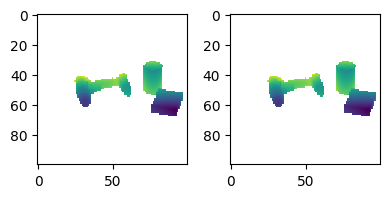

In [13]:
key = keysplit(key)

table_pose = b.t3d.inverse_pose(
    b.t3d.transform_from_pos_target_up(
        jnp.array([0.0, 2.0, 1.20]),
        jnp.array([0.0, 0.0, 0.0]),
        jnp.array([0.0, 0.0, 1.0]),
    )
)

w0, tr0 = importance_jit(key, genjax.choice_map({
    "parent_0": -1,
    "parent_1": 0,
    "parent_2": 0,
    "parent_3": 0,
    "id_0": jnp.int32(21),
    # "id_1": jnp.int32(0),
    "camera_pose": jnp.eye(4),
    "root_pose_0": table_pose,
    "face_parent_1": 2,
    "face_parent_2": 2,
    "face_parent_3": 2,
    "face_child_1": 3,
    "face_child_2": 3,
    "face_child_3": 3,
    "variance": 0.00001**2,
    "outlier_prob": 0.0,
}), (
    jnp.arange(4),
    jnp.arange(22),
    jnp.array([-jnp.ones(3)*100.0, jnp.ones(3)*100.0]),
    jnp.array([jnp.array([-0.2, -0.2, -2*jnp.pi]), jnp.array([0.2, 0.2, 2*jnp.pi])]),
    b.RENDERER.model_box_dims, OUTLIER_VOLUME, 1.0)
)
print(tr0.get_score())
print(jnp.min(get_observed_image(tr0)[...,2]), jnp.max(get_observed_image(tr0)[...,2]))

_, tr1 = importance_jit(key, tr0.get_choices(), (jnp.arange(1), jnp.arange(22), *tr0.get_args()[2:]))


def prep_image(im, far=_far, eps=0.0):
    im_ = jnp.where(im <far - eps, im, jnp.inf)
    return im_




# =======================
fig, axs = plt.subplots(1,2,figsize=(4,2))
axs[0].imshow(prep_image(get_observed_image(tr0)[...,2], eps=0.1), cmap="viridis")
axs[1].imshow(prep_image(get_rendered_image(tr0)[...,2]), cmap="viridis")
fig.tight_layout()

In [14]:
def get_ids(tr): 
    ids = np.array([np.array(tr[f"id_{i}"]).tolist() for i in range(1,4)])
    order = np.argsort(ids)
    return ids[order], order

In [15]:
ch = tr0.strip()

In [186]:
import pickle

ex = 4
ch = tr0.strip()
with open(f"_temp/ex_{ex}.pickle", "wb") as f:
    pickle.dump(ch, f)

In [187]:
ex = 4
ch = None
with open(f"_temp/ex_{ex}.pickle", "rb") as f:
    global ch;
    ch = pickle.load(f)

(100, 100)
2.1598034 5.0
(100, 100) (100, 100) (100, 100, 3)


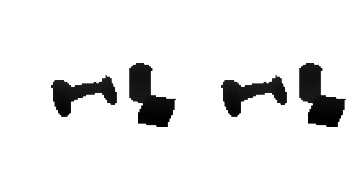

In [16]:
from scipy.ndimage import gaussian_filter

# Y0 = get_rendered_image(tr0)
# Z0 = jnp.linalg.norm(Y0[...,:3], axis=-1, keepdims=True)

# Z  = gaussian_filter(Z0, sigma = 0.0)
# dZ = 0.02*np.random.randn(*Z.shape)
# Z = jnp.where(Z < _far, Z + dZ, Z)

# Y = Y0[...,:3]/Z0*Z
# Y = clip_depth(Y, _far)

Y0 = get_rendered_image(tr0)
Z0 = Y0[...,2]
Z  = gaussian_filter(Z0, sigma = 0.0)
dZ = 0.0*np.random.randn(*Z.shape)
Z = jnp.where(Z < _far, Z + dZ, Z)

print(Z.shape)
Y = Y0.at[...,2].set(Z)

print(jnp.min(Y[...,2]), jnp.max(Y[...,2]))


ch = add_constraints(Y, ch)


_, tr1 = importance_jit(key, ch, tr1.get_args())


print(Z0.shape, Z.shape, Y.shape)
tr = tr1
# =======================
fig, ax = plt.subplots(1,1,figsize=(4,2))
ax.axis("off")
ax.imshow(jnp.concatenate([Z0,Y[...,2]], axis=1), cmap="binary_r", vmax=3.5)
fig.tight_layout()

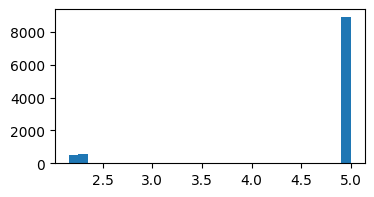

In [17]:
plt.figure(figsize=(4,2))
plt.hist(Z.ravel(), bins=30);

In [21]:
# OUTLIER_VOLUME = 1000.0
# sigs = jnp.sqrt(jnp.array([0.0001, 0.001, 0.01]))
# outs = jnp.array([0.00001, 0.0001, 0.001])

# grid_params = [
#     (0.3, jnp.pi, (11,11,11)), 
#     (0.2, jnp.pi, (11,11,11)), 
#     (0.1, jnp.pi, (11,11,11)),
#     (0.05, jnp.pi/3, (11,11,11)), 
#     (0.02, jnp.pi, (5,5,51)), 
#     (0.01, jnp.pi/5, (11,11,11)),
#     (0.01, 0.0, (21,21,1)),
#     (0.05, 0.0, (21,21,1))
# ]
# contact_grids = [
#     b.utils.make_translation_grid_enumeration_3d(
#         -x, -x, -ang,
#         x, x, ang,
#         *nums
#     )
#     for (x,ang,nums) in grid_params
# ]


In [38]:
# grid_params = [
#     # (0.3, jnp.pi, (11,11,11)), 
#     (0.2, jnp.pi, (17,17,11)), 
#     (0.1, jnp.pi, (11,11,11)),
#     (0.05, jnp.pi/3, (11,11,11)), 
#     (0.02, jnp.pi, (5,5,51)), 
#     (0.01, jnp.pi/5, (11,11,11)), 
#     (0.01, 0.0, (21,21,1)),
#     (0.05, 0.0, (21,21,1))
# ]

grid_params = [
    (0.3, jnp.pi,   (19,19,19)),
    (0.2, jnp.pi/2,   (19,19,19)),
    (0.1, jnp.pi/4,   (19,19,19)),
    # (0.2, jnp.pi/2, (15,15,15)), 
    # (0.1, jnp.pi/4, (15,15,15)),
    # (0.05, jnp.pi/8, (11,11,11)),
    # (0.01, jnp.pi/16, (11,11,11)),
    # (0.01, 0.0, (21,21,1))
]

contact_grids = [
    b.utils.make_translation_grid_enumeration_3d(
        -x, -x, -ang,
        x, x, ang,
        *nums
    )
    for (x,ang,nums) in grid_params
]


In [39]:
key   = keysplit(key)
trace = tr1

sigs  = jnp.array([0.001, 0.01, 0.1])
outs  = jnp.array([1e-4, 1e-2, 1e-1])
# outs  = jnp.array([0.001, 0.01, 0.1])
# outs  = jnp.array([0.001, 0.01, 0.1])

# sigs  = jnp.array([0.001])
# outs  = jnp.array([1e-3])
# outs  = jnp.array([0.001])


all_all_paths = []
obj_scs = []

#
# Iteratively add 3 new objects
#
for _ in range(3):
    
    all_paths = []

    #
    # Try and fit each object using a 
    # coarse-to-fine schedule
    #
    for obj_id in tqdm(range(len(b.RENDERER.meshes)-1)):
    
        path = []
    
        trace_ = add_object_jit(trace, key, obj_id, 0, 2, 3)
        number = b.get_contact_params(trace_).shape[0] - 1
        path.append(trace_)

        #
        # Coarse-to-fine schedule
        #
        for c2f_iter in range(len(contact_grids)):

            trace_, sc_ = eval_grids(trace_, key, number,
                                contact_grids[c2f_iter], 
                                sigs**2, 
                                outs)
            path.append(trace_)

        all_paths.append(path)

    all_all_paths.append(all_paths)

    # 
    # Choose the objects that fits best 
    # 
    scores = jnp.array([t[-1].get_score() for t in all_paths])
    obj_scs.append(scores - logsumexp(scores))
    normalized_scores = b.utils.normalize_log_scores(scores)
    trace = all_paths[jnp.argmax(scores)][-1]


print(tr0.score)
print(trace.score)



tr = trace

print(get_ids(tr0))
print(get_ids(tr))

100%|██████████| 21/21 [00:20<00:00,  1.02it/s]

225632.61
71158.445
(array([ 3,  6, 14]), array([1, 0, 2]))
(array([ 1,  6, 14]), array([0, 2, 1]))


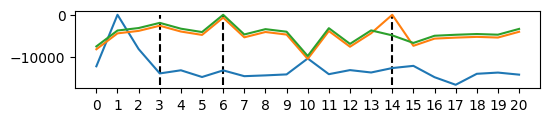

In [35]:
plt.figure(figsize=(6,1))

plt.xticks(range(len(b.RENDERER.meshes)-1))

ids0, _ = get_ids(tr0)
for i in ids0: plt.vlines(i, jnp.min(jnp.concatenate(obj_scs)),jnp.max(jnp.concatenate(obj_scs)), color="k", linestyle="--")
for s in obj_scs:
    plt.plot(range(len(b.RENDERER.meshes)-1), s)

(array([ 3,  6, 14]), array([1, 0, 2]))
(array([ 1,  6, 14]), array([0, 2, 1]))


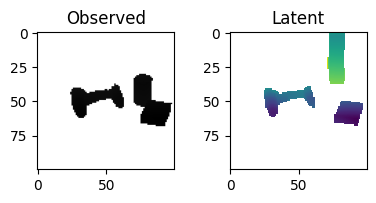

In [36]:
tr = trace

print(get_ids(tr0))
print(get_ids(tr))

# =======================
fig, axs = plt.subplots(1,2,figsize=(4,2))
axs[0].set_title("Observed")
axs[0].imshow(get_observed_image(tr)[...,2], cmap="binary_r")
axs[1].set_title("Latent")
axs[1].imshow(prep_image(get_rendered_image(tr)[...,2]), cmap="viridis")
fig.tight_layout()

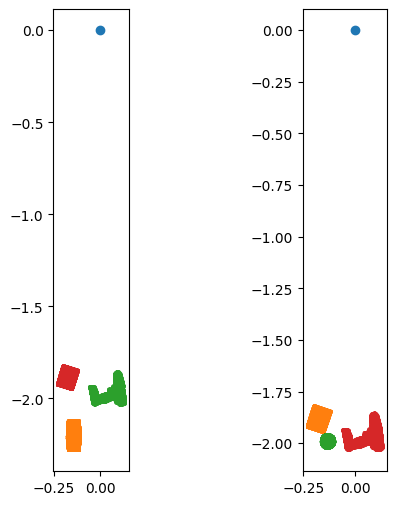

In [37]:

tr = trace
ps = get_poses(tr) 
ps0 = get_poses(tr0) 

# =======================
fig, axs = plt.subplots(1,2,figsize=(6,6))
axs[0].set_aspect(1)
axs[1].set_aspect(1)
axs[0].scatter(0,0)
axs[1].scatter(0,0)

for i in range(1,4):
    x,r = unpack_pose(ps[i])
    xs  = meshes[tr[f"id_{i}"]].vertices@r.T + x
    xs  = xs@table_pose[:3,:3].T
    axs[0].scatter(*xs[:,[0,1]].T, s=0.1)

    x,r = unpack_pose(ps0[i])
    xs  = meshes[tr0[f"id_{i}"]].vertices@r.T + x
    xs  = xs@table_pose[:3,:3].T
    axs[1].scatter(*xs[:,[0,1]].T, s=0.1)